# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

---

### Business Understanding - prompt

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<h2 style="color:darkblue;">Business Understanding - Answer</h2>

This as a supervised regression problem: learn a function f(X)→y, where the target variable y is (log) used-car price and the predictor variables X include vehicle attributes and market/context features (e.g., make/model/trim, model year/age, mileage, condition, body type, engine/transmission/fuel, options, seller type, location/market, and listing metadata), with data preparation to handle missingness, outliers, encoding, and to prevent leakage.

Our modeling objective is twofold: 
(1) accurate price estimation and 
(2) driver attribution-quantifying the marginal effect of each factor on price while controlling for confounders and interactions. We will evaluate candidate models (e.g., linear regresssion, multiple linear regression and regularized linear models) using a predefined test design (K-fold cross-validation) and metrics such as MAE/RMSE and Rsq  against a naive baseline. 

To translate results into business insight, we will use model interpretability techniques to produce a ranked list of key price drivers with effect sizes and practical thresholds (e.g., mileage bands, age cutoffs), forming the basis for dealership pricing and acquisition recommendations.

<h2 style="color:darkblue;">Methods</h2>

We restrict the modeling dataset to vehicles priced `$3,000`–`$60,000`and ≤`15` years old to align the analysis with a mainstream used-car dealership’s core inventory and customers. 

This band captures the bulk of retail transactions that are purchased for transportation utility (not collectability) and commonly financed through standard lenders; it excludes ultra-cheap listings that are often down-payments, salvage/parts cars, or data entry errors, and trims the luxury/exotic tail whose pricing is driven by different factors (brand halo, scarcity, bespoke options). 

Limiting age to ≤15 years further removes vintage/collector dynamics and vehicles with atypical condition risk, while keeping models with comparable feature sets, reliability expectations, and reconditioning costs. Practically, this policy improves label validity, reduces high-leverage outliers, and yields a model that’s actionable for pricing, acquisition, and appraisal decisions in the dealership’s target market.

---

### Data Understanding - prompt

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

<h2 style="color:darkblue;">Data Understanding - steps and checks</h2>

Below are the steps we are going to tke to get to know the dataset and identify any potential quality issues with the dataset:

1) Inventory the data (Data Description)
2) Target inspection (Price)
3) Univariate profiling (Features)
4) Bivariate exploration (Signals that inform the business)
    - core relationships
    - interactions
5) Quality checks (Data Quality Report)
    - Missingness
    - Inconsistencies & constraints
    - Outliers
    - Duplicates
    - Text normalization
    - Encoding
6) Leakage & bias scan
7) Feature engineering
8) Tie back to business understanding - Draft initial hypotheses with business wording

<h3 style="color:darkblue;">1) Data Description</h3>

- **id** - Unique identifier for the listing.
- **region** - Geographic region/metro where the listing was posted.
- **price** - Seller’s asking price in USD.
- **year** - Vehicle model year.
- **manufacturer** - Vehicle manufacturer/brand.
- **model** - Model name as provided by the seller.
- **condition** - Seller-reported condition category (e.g., new, like new, excellent, good, fair, salvage).
- **cylinders** - Engine cylinder count as stated (e.g., “4 cylinders,” “6 cylinders”).
- **fuel** - Fuel type (e.g., gas, diesel, hybrid, electric).
- **odometer** - Mileage recorded on the vehicle’s odometer.
- **title_status** - Vehicle title status (e.g., clean, salvage, rebuilt, lien, missing).
- **transmission** - Transmission type (automatic, manual, other/unknown).
- **VIN** - Vehicle Identification Number (17-character code).
- **drive** - Drivetrain (FWD, RWD, 4WD/AWD).
- **size** - Vehicle size class (e.g., sub-compact, compact, mid-size, full-size).
- **type** - Body type (e.g., sedan, SUV, pickup, coupe, hatchback, wagon, convertible).
- **paint_color** - Exterior paint color.
- **state** - Two-letter U.S. state/territory code for the listing location.

In [40]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Disable scientific notation globally for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [41]:
# Load CSV file into a DataFrame
df = pd.read_csv('data/vehicles.csv')

# preview the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [42]:
# Descriptive statistics

df.describe()

,id,price,year,odometer
count,426880.00,426880.00,425675.00,422480.00
mean,7311486634.22,75199.03,2011.24,98043.33
std,4473170.41,12182282.17,9.45,213881.50
min,7207408119.00,0.00,1900.00,0.00
25%,7308143339.25,5900.00,2008.00,37704.00
50%,7312620821.00,13950.00,2013.00,85548.00
75%,7315253543.50,26485.75,2017.00,133542.50
max,7317101084.00,3736928711.00,2022.00,10000000.00


### Duplicated observations

Based on the number of unique VIN values - it appears we might have a large number of duplicated cars in the dataset. We will examine and remove the duplicated entires before we preform further examination.

VINs are globally unique to a vehicle, but this dataset is a scrape of listings. The same car can appear multiple times (reposts after price changes, multiple dealers/locations, syndication across sites, or data-entry issues like placeholder/invalid VINs). 

For modeling, duplicates can inflate performance (leakage) and overweight a few cars. So we will deduplicate the dataset.

We will apply a multi-step deduplication strategy to improve data quality and reduce redundancy. First, we'll remove exact duplicate rows and duplicate listing IDs. Then, we'll deduplicate by VIN using a custom ranking that prioritizes rows with the highest completeness, valid price and odometer values, and the highest price. This approach ensures that only the most informative record per vehicle is retained, minimizing noise and preserving valuable data for modeling.

In [43]:
# QUICK DUPLICATES REPORT 

def duplicates_report(df):
    rep = {}
    rep["exact_duplicates"] = int(df.duplicated().sum())
    if "id" in df.columns:
        rep["duplicate_id_rows"] = int(df.duplicated(subset=["id"], keep=False).sum())
    if "VIN" in df.columns:
        rep["duplicate_VIN_rows"] = int(df.duplicated(subset=["VIN"], keep=False).sum())
        rep["duplicate_VIN_count"] = int((df["VIN"].value_counts(dropna=True) > 1).sum())
    return pd.Series(rep)

print("=== DUPLICATES REPORT ===")
print(duplicates_report(df))

=== DUPLICATES REPORT ===
exact_duplicates            0
duplicate_id_rows           0
duplicate_VIN_rows     348914
duplicate_VIN_count     40280
dtype: int64


In [44]:
# Peek at a few duplicate VIN groups

if "VIN" in df.columns:
    dup_vin_groups = (df[df.duplicated("VIN", keep=False)]
                      .sort_values("VIN")) \
                      .groupby("VIN", dropna=True).size().sort_values(ascending=False).head(10)
    print("\nTop duplicate VIN groups (VIN -> count):\n", dup_vin_groups)


Top duplicate VIN groups (VIN -> count):
 VIN
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
1GTN1TEH5EZ273019    207
3VWF17AT1FM655022    199
JN1AZ4EH8KM420880    198
1FTMF1CP3GKD62143    195
1GTR1WE07DZ143724    194
dtype: int64


In [45]:
# 1) DROP EXACT DUPLICATE ROWS 
df_dedup = df.drop_duplicates().copy()

# 2) DROP DUPLICATE ids
if "id" in df_dedup.columns:
    df_dedup = df_dedup.drop_duplicates(subset=["id"], keep="first")

# 3) DEDUPE BY VIN (keep “best” row per VIN)
def pick_best_rows_per_key(df, key):
    """
    For each 'key' group (e.g., VIN), keep one 'best' row:
      1) most non-null fields (highest completeness)
      2) has non-null price
      3) has non-null odometer
      4) highest price (numeric)
    NaN keys are not de-duplicated (kept as-is).
    """
    if key not in df.columns:
        return df

    # Ensure numeric price for ranking
    price = pd.to_numeric(df["price"], errors="coerce") if "price" in df.columns else pd.Series(np.nan, index=df.index)

    keep_idx = []
    for key_val, g in df.groupby(key, dropna=False):
        # Skip de-duping NaN keys
        if pd.isna(key_val):
            keep_idx.extend(g.index.tolist())
            continue
        if len(g) == 1:
            keep_idx.append(g.index[0])
            continue

        # Ranking keys
        completeness = g.notna().sum(axis=1)
        has_price = price.loc[g.index].notna().astype(int)
        has_odo = g["odometer"].notna().astype(int) if "odometer" in g.columns else pd.Series(0, index=g.index)
        price_num = price.loc[g.index].fillna(-1)  # lower than any valid price

        rank_df = pd.DataFrame({
            "completeness": completeness,
            "has_price": has_price,
            "has_odo": has_odo,
            "price_num": price_num,
        }, index=g.index)

        # Sort by (most complete, has price, has odometer, highest price)
        best_idx = (rank_df
                    .sort_values(["completeness","has_price","has_odo","price_num"],
                                 ascending=[False, False, False, False])
                    .index[0])
        keep_idx.append(best_idx)

    return df.loc[sorted(set(keep_idx))].copy()

if "VIN" in df_dedup.columns:
    df_dedup = pick_best_rows_per_key(df_dedup, "VIN")

print("\n=== AFTER DEDUP ===")
print(duplicates_report(df_dedup))
print("Rows:", len(df), "->", len(df_dedup))


=== AFTER DEDUP ===
exact_duplicates            0
duplicate_id_rows           0
duplicate_VIN_rows     161042
duplicate_VIN_count         0
dtype: int64
Rows: 426880 -> 279288


In [46]:
# 161042 is the number of VIN missing values

In [47]:
OUTPUT_PATH = "vehicles_deduped.csv"
df_dedup.to_csv(OUTPUT_PATH, index=False)
print(f"Saved {len(df_dedup):,} rows to {OUTPUT_PATH}")

Saved 279,288 rows to vehicles_deduped.csv


In [48]:
df = df_dedup
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Target inspection

We will exclude vehicles older than 15 years from the mainstream pricing model because they belong to a distinct collector market. Prices for these vehicles are driven by factors (rarity, originality, provenance, restoration quality) that are not observed in our dataset, which produces nonlinear trends and much higher variance in the price–year relationship. Including them degrades model fit for regular used cars and risks biased insights. We therefore model vehicles ≤15 years to provide reliable, actionable guidance for the dealership’s core inventory, and recommend a separate workflow (specialist comps or a dedicated model) for vintage/classic vehicles.

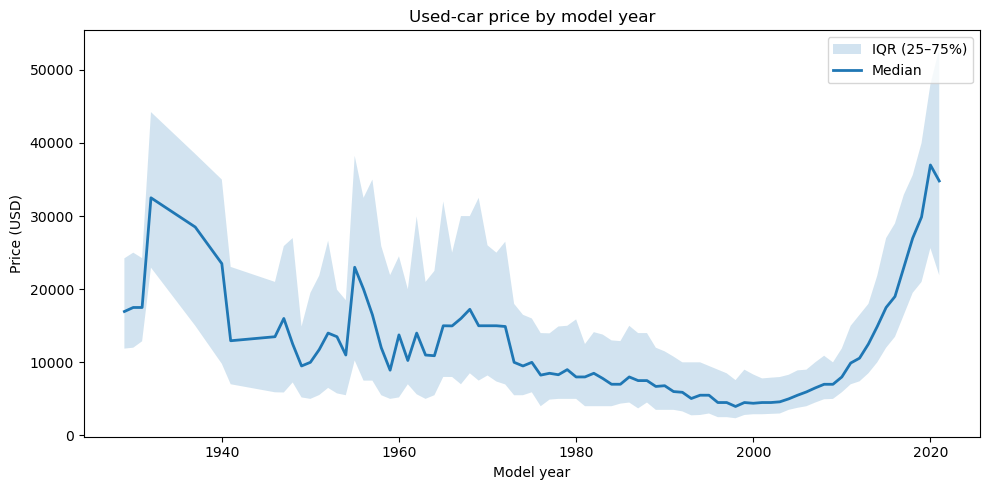

In [49]:
# price per year chart

d = df.copy()
d["price"] = pd.to_numeric(d["price"], errors="coerce")
d["year"]  = pd.to_numeric(d["year"],  errors="coerce").round()

# keep sensible ranges (adjust if you want)
d = d[d["price"].between(500, 200_000) & d["year"].between(1900, 2026)]
d = d[["year","price"]].dropna()

# aggregate by year
MIN_N = 50
g = (d.groupby("year")["price"]
       .agg(count="count",
            p25=lambda s: s.quantile(0.25),
            median="median",
            p75=lambda s: s.quantile(0.75))
       .reset_index())

g = g[g["count"] >= MIN_N].sort_values("year")

# make sure arrays are float, not object
x  = pd.to_numeric(g["year"],   errors="coerce").to_numpy(dtype=float)
y1 = pd.to_numeric(g["p25"],    errors="coerce").to_numpy(dtype=float)
ym = pd.to_numeric(g["median"], errors="coerce").to_numpy(dtype=float)
y2 = pd.to_numeric(g["p75"],    errors="coerce").to_numpy(dtype=float)

# drop any rows that turned NaN after coercion
m = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(ym) & ~np.isnan(y2)
x, y1, ym, y2 = x[m], y1[m], ym[m], y2[m]

plt.figure(figsize=(10,5))
plt.fill_between(x, y1, y2, alpha=0.2, label="IQR (25–75%)")
plt.plot(x, ym, linewidth=2, label="Median")
plt.title("Used-car price by model year")
plt.xlabel("Model year"); plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout(); plt.show()

In [50]:
# Examine how much vintage cars skew prediction

df1 = df.copy()
df1["price"] = pd.to_numeric(df1["price"], errors="coerce")
df1["year"]  = pd.to_numeric(df1["year"], errors="coerce")
REF = int(np.nanmax(df1["year"]))
df1["age"] = (REF - df1["year"]).clip(lower=0)
d = df1[["price","age"]].dropna()
d = d[d["price"].between(500, 200_000)]

vintage_mask = d["age"] > 15

def eval_simple(data):
    X = data[["age"]].to_numpy()
    y = data["price"].to_numpy()
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    m = LinearRegression().fit(Xtr, ytr)
    pred = m.predict(Xte)
    mae = mean_absolute_error(yte, pred)
    rmse = mean_squared_error(yte, pred, squared=False)
    return mae, rmse, m.coef_[0], m.intercept_

def quick_stats(s):
    return dict(n=len(s), median=float(s.median()), p25=float(s.quantile(.25)), p75=float(s.quantile(.75)))

print("Vintage share (>15y):", f"{vintage_mask.mean()*100:.1f}%")
print("Price stats — vintage:", quick_stats(d.loc[vintage_mask, "price"]))
print("Price stats — non-vintage:", quick_stats(d.loc[~vintage_mask, "price"]))

mae_all, rmse_all, slope_all, _ = eval_simple(d)
mae_nv,  rmse_nv,  slope_nv,  _ = eval_simple(d.loc[~vintage_mask])

print("\nSimple model: price ~ age")
print(f"All data     → MAE ${mae_all:,.0f}, RMSE ${rmse_all:,.0f}, slope ${slope_all:,.0f}/year")
print(f"≤15 years    → MAE ${mae_nv:,.0f}, RMSE ${rmse_nv:,.0f}, slope ${slope_nv:,.0f}/year")
print(f"ΔRMSE (drop vintage): {((rmse_all - rmse_nv)/rmse_all)*100:.1f}% improvement")

Vintage share (>15y): 26.2%
Price stats — vintage: {'n': 65872, 'median': 5600.0, 'p25': 3500.0, 'p75': 10000.0}
Price stats — non-vintage: {'n': 185175, 'median': 14590.0, 'p25': 7995.0, 'p75': 24943.0}

Simple model: price ~ age
All data     → MAE $9,711, RMSE $13,656, slope $-348/year
≤15 years    → MAE $8,255, RMSE $12,033, slope $-2,158/year
ΔRMSE (drop vintage): 11.9% improvement


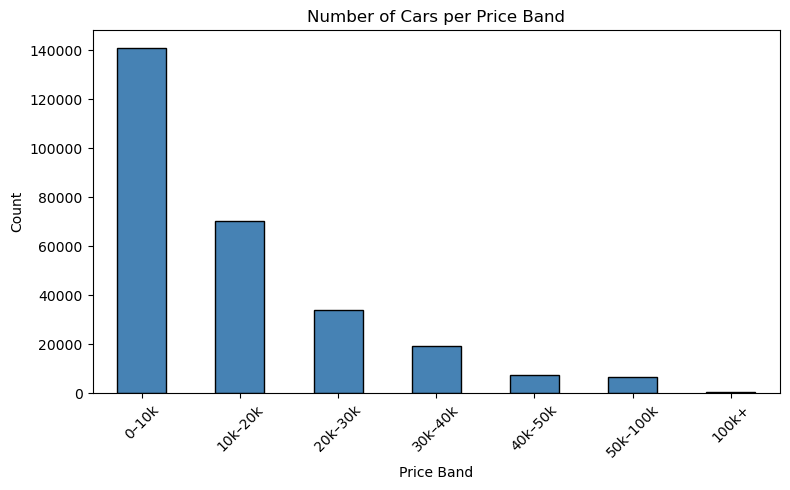

In [51]:
# Examine the number of cars per price band

# Define price bands including overflow
bins = [0, 10000, 20000, 30000, 40000, 50000, 100000, float("inf")]
labels = ["0–10k", "10k–20k", "20k–30k", "30k–40k", "40k–50k", "50k–100k", "100k+"]

# Create binned column
df["price_band"] = pd.cut(df["price"], bins=bins, labels=labels, right=False)

# Count cars per band
band_counts = df["price_band"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
band_counts.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Number of Cars per Price Band")
plt.xlabel("Price Band")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Preparation - prompt

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

<h2 style="color:darkblue;">Data Preparation</h2>

We performed initial data cleaning to ensure the dataset accurately reflects individual vehicle listings. First, we removed price outliers below `$3,000` and above `$60,000`, and cars older than 15 years - as explained in the Methods section. We excluded entries with missing manufacturer information and filtered out listings where the model name contained the word "finance," which typically indicated promotional or non-vehicle records. Finally, we derived vehicle age from the model year. 

#### Variables to drop:

- **id** - not needed for business understanding or prediction
- **VIN** - not needed for business understanding or prediction
- **year** - replaced by the age variable
- **region** - strong overlap with state (based on initial runs of Cramer's Association Matrix - 0.98 association coefficient with state)
- **model** - too much cardinality and messy data and strong overalp with other variables (based on initial runs of Cramer's Association Matrix - 0.72 association coefficient with manufacturer)

In [52]:
# 1) Target variable (price): keep only $3,000–$60,000 (drops NaNs automatically)
df["price"] = pd.to_numeric(df["price"], errors="coerce")
mask_price = (df["price"] >= 3_000) & (df["price"] <= 60_000)

# 2) Drop rows with blank/whitespace/NaN manufacturer
manu = df["manufacturer"]
mask_manu = manu.notna() & manu.astype(str).str.strip().ne("")

# 3) Drop rows where 'model' contains the word "finance" (case-insensitive)
mask_model = ~df["model"].astype(str).str.contains(r"\bfinance\b", case=False, na=False)

# 4) Calculate age and exclude cars older than 15 years
df["year"] = pd.to_numeric(df["year"], errors="coerce")
latest_year = int(np.nanmax(df["year"]))
df["age"] = (latest_year - df["year"]).clip(lower=0)
mask_age = df["age"] <= 15

# apply all filters
df_clean = df.loc[mask_price & mask_manu & mask_model & mask_age].copy()

In [53]:
df = df_clean
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,price_band,age
27,7316814884,auburn,33590,2014.00,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.00,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white,al,30k–40k,8.00
28,7316814758,auburn,22590,2010.00,chevrolet,silverado 1500,good,8 cylinders,gas,71229.00,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue,al,20k–30k,12.00
29,7316814989,auburn,39590,2020.00,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.00,clean,other,3GCPWCED5LG130317,NaN,NaN,pickup,red,al,30k–40k,2.00
30,7316743432,auburn,30990,2017.00,toyota,tundra double cab sr,good,8 cylinders,gas,41124.00,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,al,30k–40k,5.00
31,7316356412,auburn,15000,2013.00,ford,f-150 xlt,excellent,6 cylinders,gas,128000.00,clean,automatic,NaN,rwd,full-size,truck,black,al,10k–20k,9.00


In [56]:
# drop unnecesary variables

df = df.drop(['VIN', 'id', 'year', 'region', 'model', 'price_band'], axis=1)

In [57]:
OUTPUT_PATH = "vehicles_cleaned.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved {len(df):,} rows to {OUTPUT_PATH}")

Saved 170,962 rows to vehicles_cleaned.csv


### Feature profiling

In [58]:
# categorical variables EDA 

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(cat_cols)

['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'price_band']


In [59]:
# cat variables overview 

summary = []
for c in cat_cols:
    s = df[c]
    vc = s.value_counts(dropna=True)
    summary.append({
        "column": c,
        "missing_%": round(100*(s.isna().mean()), 2),
        "n_levels": int(s.nunique(dropna=True)),
        "top_level": (vc.index[0] if len(vc) else np.nan),
        "top_count": (int(vc.iloc[0]) if len(vc) else 0),
        "top_share_%": (round(100*vc.iloc[0]/len(s), 2) if len(vc) else 0.0),
    })
pd.DataFrame(summary).sort_values(["missing_%","n_levels"], ascending=[False, False])

,column,missing_%,n_levels,top_level,top_count,top_share_%
7,size,66.02,4,full-size,27730,16.22
1,condition,43.14,6,excellent,51008,29.84
2,cylinders,38.43,8,4 cylinders,43668,25.54
9,paint_color,29.76,12,white,30427,17.80
6,drive,28.44,3,4wd,54330,31.78
8,type,25.92,13,sedan,37873,22.15
4,title_status,1.30,6,clean,160188,93.70
3,fuel,0.66,5,gas,151689,88.73
5,transmission,0.39,3,automatic,153631,89.86
10,state,0.00,51,ca,19382,11.34


In [60]:
# cat variables frequency table function 

def freq_table(col, top=None):
    s = df[col].astype("string")
    vc = s.value_counts(dropna=False)
    if top: vc = vc.head(top)
    out = pd.DataFrame({"count": vc, "pct_%": (vc/len(s)*100).round(2)})
    return out

In [61]:
# examples:
freq_table("manufacturer", top=10)

,count,pct_%
manufacturer,,
ford,28892,16.90
chevrolet,22130,12.94
toyota,14352,8.39
honda,10661,6.24
nissan,9851,5.76
jeep,8113,4.75
ram,6574,3.85
gmc,6295,3.68
bmw,6108,3.57


In [62]:
# price by category

OVERALL_MED = df["price"].median()

def price_by(cat, min_n=50):
    g = (df.groupby(cat)["price"]
          .agg(n="count", share=lambda x: len(x)/len(df),
               p25=lambda x: x.quantile(0.25), median="median",
               p75=lambda x: x.quantile(0.75), mean="mean"))
    g = g[g["n"] >= min_n].copy()
    g["share"] = g["share"].round(3)
    g["lift_vs_overall_%"] = ((g["median"]/OVERALL_MED - 1)*100).round(1)
    return g.sort_values(["n","median"], ascending=[False, False]).round(0)

# examples:
price_by("manufacturer", min_n=100).head(5)
# price_by("drive", min_n=50)

,n,share,p25,median,p75,mean,lift_vs_overall_%
manufacturer,,,,,,,
ford,28892,0.00,9700.00,16995.00,28777.00,20332.00,13.00
chevrolet,22130,0.00,8950.00,15786.00,27000.00,19154.00,5.00
toyota,14352,0.00,8300.00,14496.00,23587.00,17310.00,-3.00
honda,10661,0.00,7000.00,10950.00,16885.00,12811.00,-27.00
nissan,9851,0.00,6990.00,10590.00,16880.00,12694.00,-29.00


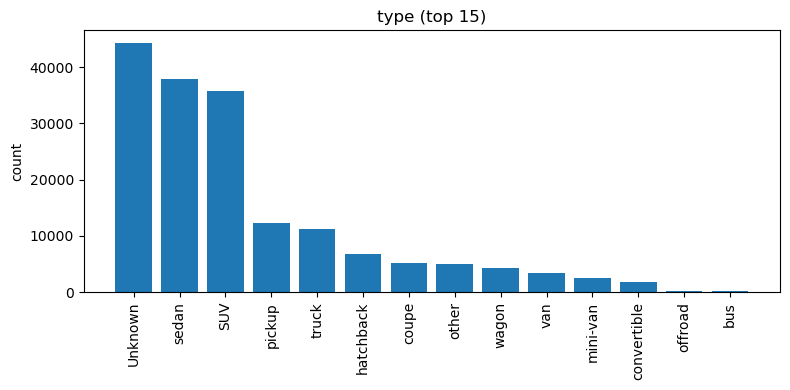

In [63]:
# bar charts 

s = df["type"]
if pd.api.types.is_categorical_dtype(s):
    s = s.cat.add_categories(["Unknown"]).fillna("Unknown")
else:
    s = s.fillna("Unknown")

vc = s.value_counts().head(15)

plt.figure(figsize=(8,4))
plt.bar(vc.index.astype(str), vc.values)
plt.xticks(rotation=90); plt.ylabel("count"); plt.title("type (top 15)")
plt.tight_layout(); plt.show()

Cramér’s V association matrix helps assess the strength of relationships between categorical variables. Each cell shows a value from 0 to 1, where higher off-diagonal values indicate stronger associations. A V ≥ 0.50 suggests redundancy—consider dropping one variable or treating one as a parent. Values between 0.30–0.49 imply moderate overlap, which may justify interaction features. Weak associations (0.10–0.29) suggest complementary signal, while values below 0.10 indicate independence. The matrix can guide feature pruning, interaction design, and flag data inconsistencies, but results should be interpreted cautiously—especially in large or sparse datasets where bias or confounding may distort associations.

            var1          var2  cramers_v
0          drive          type       0.47
1           type         drive       0.47
2          drive     cylinders       0.38
3      cylinders         drive       0.38
4           size     cylinders       0.31
5      cylinders          size       0.31
6          drive  manufacturer       0.31
7   manufacturer         drive       0.31
8           size          type       0.29
9           type          size       0.29
10          type     cylinders       0.28
11     cylinders          type       0.28
12   paint_color         drive       0.27
13         drive   paint_color       0.27
14  manufacturer          fuel       0.27
15          fuel  manufacturer       0.27
16  manufacturer     cylinders       0.25
17     cylinders  manufacturer       0.25


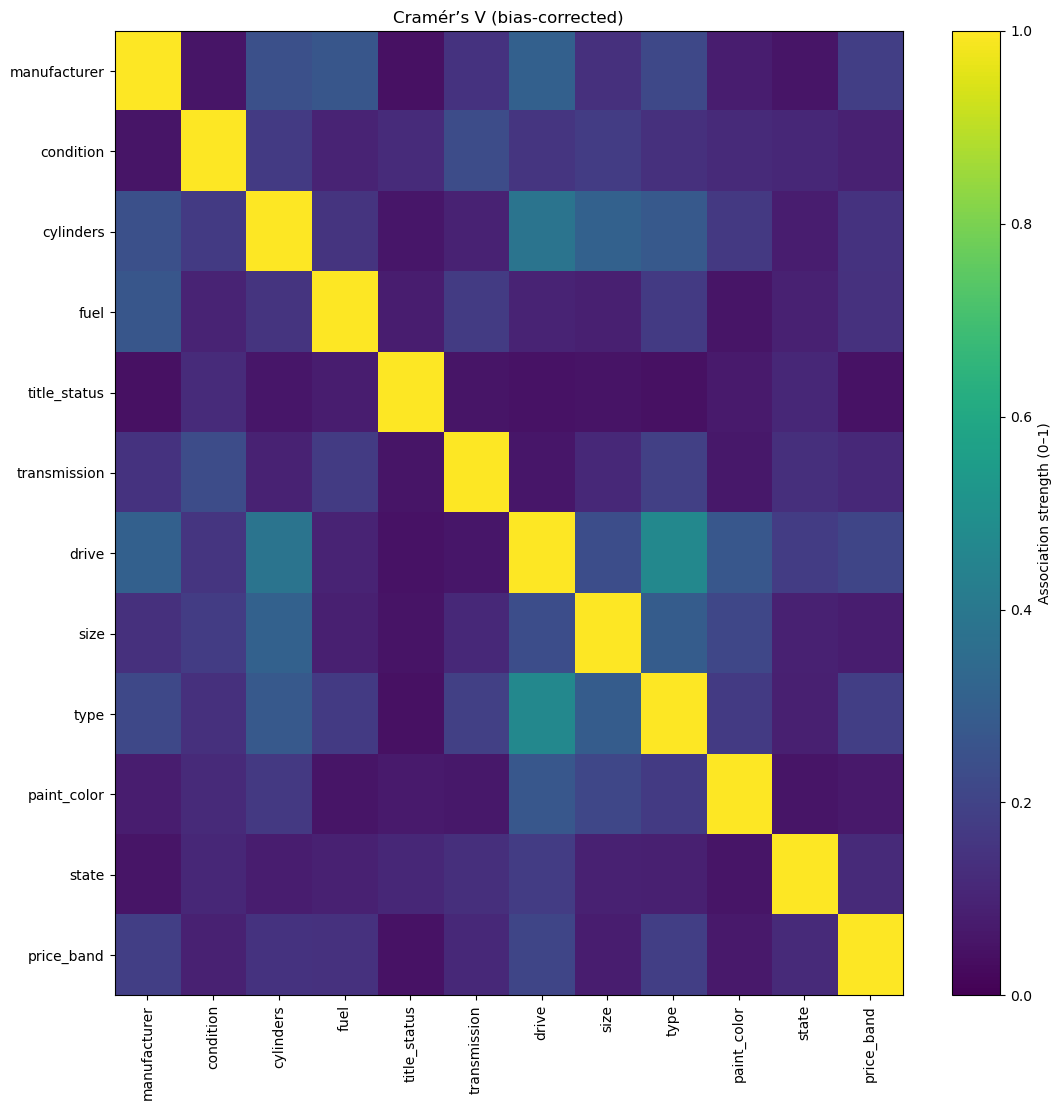

In [64]:
from scipy.stats import chi2_contingency

# Optional: collapse very rare levels to keep tables stable
def collapse_rare(s, min_count=50, other="Other"):
    s = s.astype("string")
    keep = s.value_counts()
    keep = keep[keep >= min_count].index
    return s.where(s.isin(keep), other)

df_cat = df.copy()
for c in cat_cols:
    df_cat[c] = collapse_rare(df_cat[c], min_count=50)

def cramers_v_corrected(tab: pd.DataFrame) -> float:
    """Bias-corrected Cramér's V (Bergsma/Wicher)."""
    n = tab.values.sum()
    if n == 0: return np.nan
    chi2, _, _, _ = chi2_contingency(tab, correction=False)
    phi2 = chi2 / n
    r, k = tab.shape
    # bias correction
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)*(r-1)/(n-1)
    k_corr = k - (k-1)*(k-1)/(n-1)
    denom = max(1, min(r_corr-1, k_corr-1))
    return float(np.sqrt(phi2_corr / denom)) if denom > 0 else np.nan

# Build the matrix
V = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for i, a in enumerate(cat_cols):
    for j, b in enumerate(cat_cols):
        if j < i:
            V.loc[a, b] = V.loc[b, a]
            continue
        if a == b:
            V.loc[a, b] = 1.0
        else:
            tab = pd.crosstab(df_cat[a], df_cat[b])
            V.loc[a, b] = cramers_v_corrected(tab)

V = V.astype(float)

# List strongest pairs
pairs = (
    V.where(~np.eye(len(V), dtype=bool))
     .stack()
     .sort_values(ascending=False)
     .reset_index()
     .rename(columns={"level_0":"var1","level_1":"var2",0:"cramers_v"})
)
print(pairs.head(18))

# Heatmap (plain matplotlib)
plt.figure(figsize=(0.6*len(V.columns)+4, 0.6*len(V.index)+4))
plt.imshow(V.values, vmin=0, vmax=1, aspect='auto', interpolation='nearest')
plt.xticks(range(len(V.columns)), V.columns, rotation=90)
plt.yticks(range(len(V.index)), V.index)
plt.title("Cramér’s V (bias-corrected)")
plt.colorbar(label="Association strength (0–1)")
plt.tight_layout(); plt.show()

### Missing Data Analysis

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170962 entries, 27 to 426830
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         170962 non-null  int64   
 1   manufacturer  170962 non-null  object  
 2   condition     97212 non-null   object  
 3   cylinders     105256 non-null  object  
 4   fuel          169833 non-null  object  
 5   odometer      169679 non-null  float64 
 6   title_status  168731 non-null  object  
 7   transmission  170293 non-null  object  
 8   drive         122332 non-null  object  
 9   size          58091 non-null   object  
 10  type          126641 non-null  object  
 11  paint_color   120083 non-null  object  
 12  state         170962 non-null  object  
 13  price_band    170962 non-null  category
 14  age           170962 non-null  float64 
dtypes: category(1), float64(2), int64(1), object(11)
memory usage: 19.7+ MB


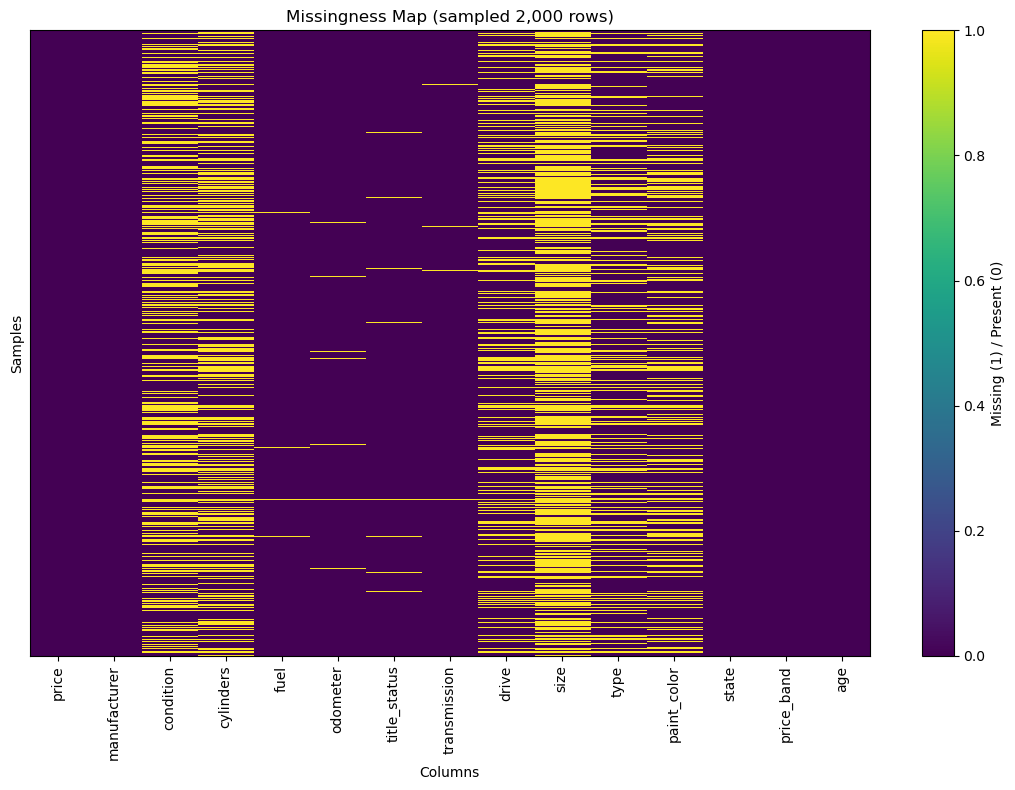

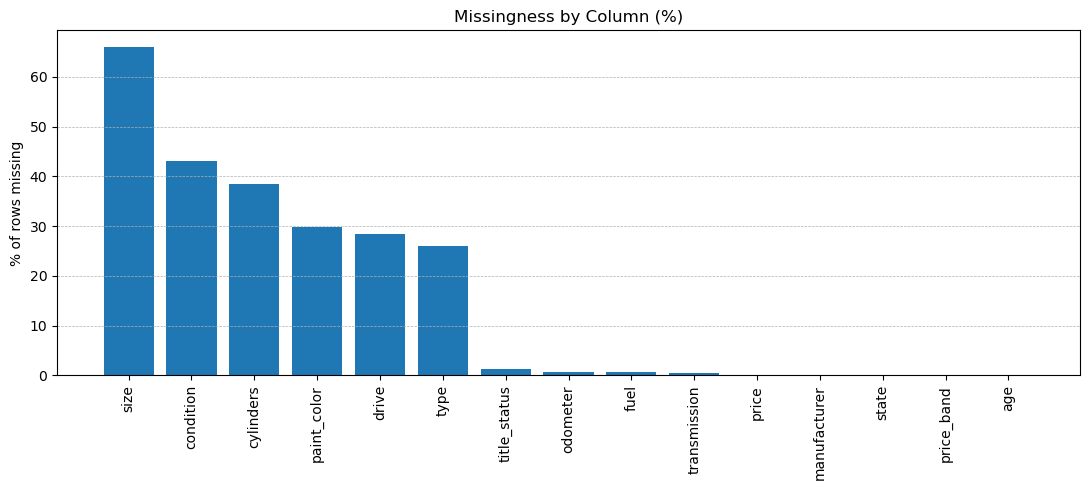

In [66]:
# 1) Missingness map (sampled rows)
N = min(2000, len(df))  # adjust if needed
missing = df.isna().astype(int)
missing_s = missing.sample(n=N, random_state=42) if len(df) > N else missing

cols = df.columns.tolist()  # dynamically get all column names

plt.figure(figsize=(max(8, 0.6*len(cols)+2), 8))
plt.imshow(missing_s.values, aspect="auto", interpolation="nearest")
plt.title(f"Missingness Map (sampled {len(missing_s):,} rows)")
plt.xlabel("Columns")
plt.ylabel("Samples")
plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=90)
plt.yticks([])  # hide crowded y-ticks
plt.colorbar(label="Missing (1) / Present (0)")
plt.tight_layout()
plt.show()

# 2) Missingness by column (bar chart)
miss_pct = missing.mean().sort_values(ascending=False) * 100

plt.figure(figsize=(max(8, 0.6*len(cols)+2), 5))
plt.bar(miss_pct.index, miss_pct.values)
plt.title("Missingness by Column (%)")
plt.ylabel("% of rows missing")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [67]:
# size has over 60% of missing values so drop it for now

df = df.drop(['size'], axis=1)

In [68]:
df.head()

,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price_band,age
27,33590,gmc,good,8 cylinders,gas,57923.00,clean,other,NaN,pickup,white,al,30k–40k,8.00
28,22590,chevrolet,good,8 cylinders,gas,71229.00,clean,other,NaN,pickup,blue,al,20k–30k,12.00
29,39590,chevrolet,good,8 cylinders,gas,19160.00,clean,other,NaN,pickup,red,al,30k–40k,2.00
30,30990,toyota,good,8 cylinders,gas,41124.00,clean,other,NaN,pickup,red,al,30k–40k,5.00
31,15000,ford,excellent,6 cylinders,gas,128000.00,clean,automatic,rwd,truck,black,al,10k–20k,9.00


#### Missing data imputation

In [69]:
# Impute odometer with median by age
df['odometer'] = df.groupby('age')['odometer'].transform(
    lambda x: x.fillna(x.median())
)

# impute missing values for the cat variables with "unknown"
cols = ["fuel","condition","title_status","transmission","drive","type","paint_color"]

for c in cols:
    s = df[c].astype("string")                          # normalize type
    s = s.where(~s.str.strip().eq(""), pd.NA)           # blanks → NA
    df[c] = s.fillna("unknown")   

In [70]:
# cylinders - impute with a median by type and bucketize

# 1) parse cylinders to numeric
CYL_MAP = {
    "3 cylinders": 3, "4 cylinders": 4, "5 cylinders": 5, "6 cylinders": 6,
    "8 cylinders": 8, "10 cylinders": 10, "12 cylinders": 12,
    "other": np.nan, "unknown": np.nan, "": np.nan
}
c = df["cylinders"].astype("string").str.strip().str.lower().map(CYL_MAP).astype("Float64")

# 2) impute by TYPE median → global median
t = df["type"].astype("string")
med_by_type = c.groupby(t).median()
global_med  = c.median()
c_imp = c.fillna(t.map(med_by_type)).fillna(global_med)

# 3) bucketize
def cyl_bucket(n):
    if pd.isna(n): return "unknown"
    n = int(n)
    if n <= 4: return "cyl_3_4"
    if n == 5: return "cyl_5"
    if n == 6: return "cyl_6"
    if n == 8: return "cyl_8"
    return "cyl_10plus"

df["cyl_bucket"] = pd.Series(c_imp).map(cyl_bucket)
df = df.drop(['cylinders'], axis=1)

In [71]:
df.head()

,price,manufacturer,condition,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price_band,age,cyl_bucket
27,33590,gmc,good,gas,57923.00,clean,other,unknown,pickup,white,al,30k–40k,8.00,cyl_8
28,22590,chevrolet,good,gas,71229.00,clean,other,unknown,pickup,blue,al,20k–30k,12.00,cyl_8
29,39590,chevrolet,good,gas,19160.00,clean,other,unknown,pickup,red,al,30k–40k,2.00,cyl_8
30,30990,toyota,good,gas,41124.00,clean,other,unknown,pickup,red,al,30k–40k,5.00,cyl_8
31,15000,ford,excellent,gas,128000.00,clean,automatic,rwd,truck,black,al,10k–20k,9.00,cyl_6


In [72]:
df.isna().any().any()

False

In [ ]:
# df.isna().sum()

In [ ]:
# --- save ---
# OUTPUT_PATH = "vehicles_cleaned.csv"
# df.to_csv(OUTPUT_PATH, index=False)
# print(f"Saved {len(df):,} rows to {OUTPUT_PATH}")

### Corrplots

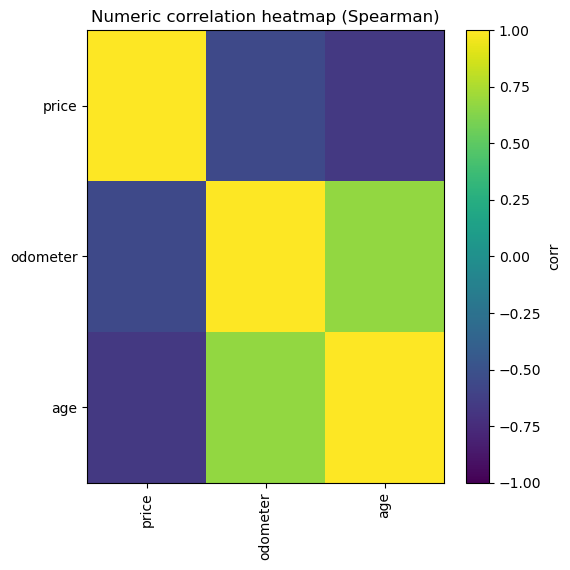

In [73]:
# corrplot

num = df.select_dtypes(include=[np.number]).copy()
c = num.corr(method="spearman")          # or "pearson"

plt.figure(figsize=(0.6*len(c.columns)+4, 0.6*len(c.columns)+4))
plt.imshow(c.values, vmin=-1, vmax=1, aspect="auto", interpolation="nearest")
plt.xticks(range(len(c.columns)), c.columns, rotation=90)
plt.yticks(range(len(c.index)), c.index)
plt.title("Numeric correlation heatmap (Spearman)")
plt.colorbar(label="corr")
plt.tight_layout(); plt.show()

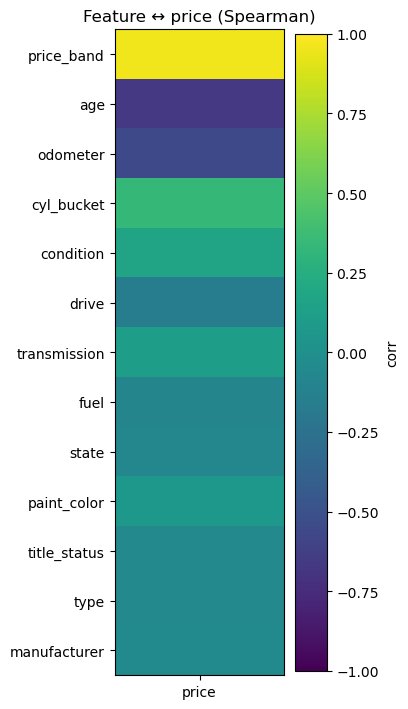

              corr_with_price
price_band               0.96
age                     -0.67
odometer                -0.56
cyl_bucket               0.33
condition                0.17
drive                   -0.15
transmission             0.11
fuel                    -0.09
state                   -0.07
paint_color              0.06
title_status            -0.06
type                    -0.06
manufacturer            -0.05


In [74]:
# correlations

target = "price"
y = pd.to_numeric(df[target], errors="coerce")

# numeric features (excluding target)
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
num_corr = pd.Series({c: pd.to_numeric(df[c], errors="coerce").corr(y, method="spearman")
                      for c in num_cols})

# categorical → codes, then Spearman with target
cat_cols = [c for c in df.columns if c not in num_cols + [target]]
cats = df[cat_cols].apply(lambda s: s.astype("category").cat.codes.replace(-1, np.nan))
cat_corr = cats.apply(lambda s: s.corr(y, method="spearman"))

# stack & sort by absolute correlation
r = (pd.concat([num_corr, cat_corr])
       .dropna()
       .sort_values(key=lambda s: s.abs(), ascending=False))

# 1-column heatmap (feature vs price)
vals = r.values.reshape(-1, 1)
plt.figure(figsize=(4, 0.4*len(r)+2))
plt.imshow(vals, vmin=-1, vmax=1, aspect="auto", interpolation="nearest")
plt.yticks(range(len(r.index)), r.index)
plt.xticks([0], [target])
plt.title("Feature ↔ price (Spearman)")
plt.colorbar(label="corr")
plt.tight_layout(); plt.show()

print(r.to_frame("corr_with_price"))

#### Price vs Log Price distribution

We will use log Price for modeling since it's closer resembles normal distribution.

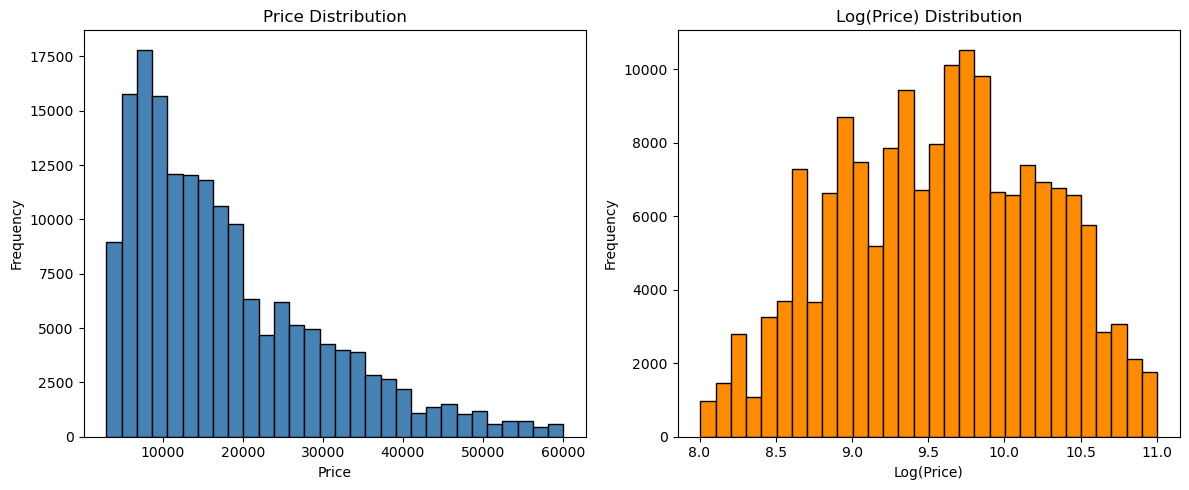

In [76]:
# Create log(price) column
df['log_price'] = np.log(df['price'])

# Plot histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of price
axes[0].hist(df['price'], bins=30, color='steelblue', edgecolor='black')
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Histogram of log(price)
axes[1].hist(df['log_price'], bins=30, color='darkorange', edgecolor='black')
axes[1].set_title('Log(Price) Distribution')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Feature engineering, bucketing, encoding...

In [77]:
df.head()

,price,manufacturer,condition,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age,cyl_bucket,log_price
27,33590,gmc,good,gas,57923.00,clean,other,unknown,pickup,white,al,8.00,cyl_8,10.42
28,22590,chevrolet,good,gas,71229.00,clean,other,unknown,pickup,blue,al,12.00,cyl_8,10.03
29,39590,chevrolet,good,gas,19160.00,clean,other,unknown,pickup,red,al,2.00,cyl_8,10.59
30,30990,toyota,good,gas,41124.00,clean,other,unknown,pickup,red,al,5.00,cyl_8,10.34
31,15000,ford,excellent,gas,128000.00,clean,automatic,rwd,truck,black,al,9.00,cyl_6,9.62


In [78]:
# create color buckets neutral, bright and other, and one-hot dropping other

def bucket_paint(s: pd.Series) -> pd.Series:
    s = s.astype("string").str.strip().str.lower().fillna("unknown")
    neutrals = {"black","white","grey","gray","silver"}
    bright   = {"red","blue","green","yellow","orange","purple"}
    return s.map(lambda c: "neutrals" if c in neutrals
                           else "bright" if c in bright
                           else "other")

df["paint_bucket"] = bucket_paint(df["paint_color"])
df = df.drop(['paint_color'], axis=1)

# (optional) sanity check
print(df["paint_bucket"].value_counts(dropna=False))

paint_bucket
neutrals    88239
other       56452
bright      26271
Name: count, dtype: int64


In [79]:
df.head()

,price,manufacturer,condition,fuel,odometer,title_status,transmission,drive,type,state,age,cyl_bucket,log_price,paint_bucket
27,33590,gmc,good,gas,57923.00,clean,other,unknown,pickup,al,8.00,cyl_8,10.42,neutrals
28,22590,chevrolet,good,gas,71229.00,clean,other,unknown,pickup,al,12.00,cyl_8,10.03,bright
29,39590,chevrolet,good,gas,19160.00,clean,other,unknown,pickup,al,2.00,cyl_8,10.59,bright
30,30990,toyota,good,gas,41124.00,clean,other,unknown,pickup,al,5.00,cyl_8,10.34,bright
31,15000,ford,excellent,gas,128000.00,clean,automatic,rwd,truck,al,9.00,cyl_6,9.62,neutrals


#### Encode

In [80]:
# Paint encoding: neutrals, bright (baseline = other)
X_paint = pd.get_dummies(df["paint_bucket"])[["neutrals", "bright"]].astype(int)
X_paint.index = df.index

# Cylinder encoding with ordered categories and drop_first
X_cyl = pd.get_dummies(
    pd.Categorical(df["cyl_bucket"], categories=["unknown", "cyl_3_4", "cyl_5", "cyl_6", "cyl_8", "cyl_10plus"]),
    drop_first=True
).astype(int)
X_cyl.index = df.index

# Other categorical variables
cols = ["fuel", "condition", "title_status", "transmission", "drive", "type"]
X_cat = pd.get_dummies(df[cols], drop_first=True).astype(int)
X_cat.index = df.index

# Normalize and simplify manufacturer
df["manufacturer"] = df["manufacturer"].astype("string").str.strip().str.lower()
counts = df["manufacturer"].value_counts()
mask_common = df["manufacturer"].map(counts) >= 50
df["manufacturer_simplified"] = df["manufacturer"].where(mask_common, "other")
df = df.drop(["manufacturer"], axis=1)

# Encode simplified manufacturer
X_manu = pd.get_dummies(df["manufacturer_simplified"], drop_first=True).astype(int)
X_manu.index = df.index

# Drop state (high cardinality, low signal)
df = df.drop(["state"], axis=1)

# Final concatenation
df = pd.concat([
    df.drop(columns=["paint_bucket", "cyl_bucket", "fuel", "condition", "title_status",
                     "transmission", "drive", "type", "manufacturer_simplified"]),
    X_paint, X_cyl, X_cat, X_manu
], axis=1)

In [81]:
print(df.shape, df.columns)

(170962, 84) Index(['price', 'odometer', 'age', 'log_price', 'neutrals', 'bright',
       'cyl_3_4', 'cyl_5', 'cyl_6', 'cyl_8', 'cyl_10plus', 'fuel_electric',
       'fuel_gas', 'fuel_hybrid', 'fuel_other', 'fuel_unknown',
       'condition_fair', 'condition_good', 'condition_like new',
       'condition_new', 'condition_salvage', 'condition_unknown',
       'title_status_lien', 'title_status_missing', 'title_status_parts only',
       'title_status_rebuilt', 'title_status_salvage', 'title_status_unknown',
       'transmission_manual', 'transmission_other', 'transmission_unknown',
       'drive_fwd', 'drive_rwd', 'drive_unknown', 'type_bus',
       'type_convertible', 'type_coupe', 'type_hatchback', 'type_mini-van',
       'type_offroad', 'type_other', 'type_pickup', 'type_sedan', 'type_truck',
       'type_unknown', 'type_van', 'type_wagon', 'alfa-romeo', 'audi', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'fiat', 'ford',
       'gmc', 'harley-davidson', 'hond

#### Final dataset

In [82]:
df.head()

,price,odometer,age,log_price,neutrals,bright,cyl_3_4,cyl_5,cyl_6,cyl_8,...,pontiac,porsche,ram,rover,saturn,subaru,tesla,toyota,volkswagen,volvo
27,33590,57923.00,8.00,10.42,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
28,22590,71229.00,12.00,10.03,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
29,39590,19160.00,2.00,10.59,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
30,30990,41124.00,5.00,10.34,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
31,15000,128000.00,9.00,9.62,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# Save final file
OUTPUT_PATH = "vehicles_final.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved {len(df):,} rows to {OUTPUT_PATH}")

Saved 170,962 rows to vehicles_final.csv


### Modeling - prompt

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

<h2 style="color:darkblue;">Modeling</h2>

In [17]:
# # Import packages

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Disable scientific notation globally for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

# import warnings
# warnings.filterwarnings('ignore')

# # Load final dataset into a DataFrame
# df = pd.read_csv('data/vehicles_final.csv')

# # preview the data
# df.info()

#### Baseline

In [84]:
# Quick baseline to compare: always predict the training median price

# ---- 1) Train / test split ----
X = df["age"].values
y = df["price"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

baseline = np.median(y_train)
mae_base = mean_absolute_error(y_test, np.full_like(y_test, baseline))
rmse_base = mean_squared_error(y_test, np.full_like(y_test, baseline), squared=False)
print("\nBaseline (predict training median):")
print(f"MAE : ${mae_base:,.0f} | RMSE: ${rmse_base:,.0f}")


Baseline (predict training median):
MAE : $9,062 | RMSE: $12,147


#### Model 1 - Multiple Linear regression on Price using Age and Odometer variables

In [85]:
# Prepare
df_use = df.copy()
for c in ["price","age","odometer"]:
    df_use[c] = pd.to_numeric(df_use[c], errors="coerce")
df_use = df_use.dropna(subset=["price","age","odometer"])

# ---- 1) Train / test split ----
X = df_use[["age", "odometer"]].to_numpy()
y = df_use["price"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---- 2) Fit linear regression (price ~ age + odometer) ----
lr = LinearRegression().fit(X_train, y_train)

# ---- 3) Evaluate ----
y_pred = lr.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("=== Test metrics ===")
print(f"MAE : ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R^2 : {r2:.3f}")

# ---- 4) Coefficients (focused) ----
print("\n=== Coefficients ===")
print(f"Intercept: ${lr.intercept_:,.2f}")
print(f"Age coefficient: ${lr.coef_[0]:,.2f} per +1 year")

odo_coef = lr.coef_[1]  # per mile
print(f"Odometer coefficient: ${odo_coef:,.4f} per mile "
      f"(≈ ${odo_coef*10_000:,.0f} per 10k miles)")


=== Test metrics ===
MAE : $7,062
RMSE: $9,231
R^2 : 0.387

=== Coefficients ===
Intercept: $34,963.45
Age coefficient: $-1,933.71 per +1 year
Odometer coefficient: $-0.0063 per mile (≈ $-63 per 10k miles)


**Interpretation** 

Holding mileage constant, each additional year of age is associated with about `$1,934` lower price on average. Holding age constant, each 10,000 miles is associated with about `$63` lower price (≈ `$0.0063` per mile). The intercept (`$34,963`) is the model’s predicted price when age and mileage are zero—mostly a mathematical anchor rather than a realistic listing, but useful for positioning the plane.

**Evaluation metrics**

   - **MAE** = `$7,062`: the typical absolute error; easy to interpret in dollars and less sensitive to outliers—good for business-facing accuracy.

   - **RMSE** = `$9.231`: square-error penalty that weights big misses more; helpful to see if the model occasionally makes large mistakes and to compare models that differ on tail behavior.

   - **R²** = `0.387`: about 37.7% of price variation explained by age and mileage alone; reasonable for a 2-feature baseline and leaves headroom for adding brand, type, state, etc.

**Why these metrics:** MAE gives a stable, dollar-level sense of typical error; RMSE highlights costly large misses; R² summarizes variance explained and is scale-free for quick comparisons. Together they provide a balanced view of business impact (MAE), risk of big misses (RMSE), and explanatory power (R²).

#### Model 2 - Multiple Linear regression on Log Price using Age and Odometer variables

In [86]:
# ----- 1) Train/test split -----
X = df[["age", "odometer"]].to_numpy()
y_log = np.log(df["price"].to_numpy())
y_price = df["price"].to_numpy()

X_tr, X_te, y_tr_log, y_te_log, y_tr_price, y_te_price = train_test_split(
    X, y_log, y_price, test_size=0.2, random_state=42
)

# ----- 2) Fit linear model on log(price) -----
m = LinearRegression().fit(X_tr, y_tr_log)

# ----- 3) Smearing correction to back-transform to dollars -----
yhat_tr_log = m.predict(X_tr)
smear = float(np.mean(np.exp(y_tr_log - yhat_tr_log)))   # Duan (1983)

yhat_te_log   = m.predict(X_te)
yhat_te_price = np.exp(yhat_te_log) * smear              # back to $ with bias fix

# ----- 4) Metrics (on $ scale and on log scale) -----
mae  = mean_absolute_error(y_te_price, yhat_te_price)
rmse = mean_squared_error(y_te_price, yhat_te_price, squared=False)
r2_  = r2_score(y_te_price, yhat_te_price)

r2_log = r2_score(y_te_log, yhat_te_log)                 # how well log-price is explained
rmspe = np.sqrt(np.mean(((yhat_te_price - y_te_price) / y_te_price) ** 2))  # percent RMSE

print("=== log-price model: log(price) ~ age + odometer ===")
print(f"Intercept (log scale): {m.intercept_:.3f}")

# Age coefficient (percent change per +1 year)
beta_age = m.coef_[0]
print(f"β_age (log scale): {beta_age:.4f}  → ~{100*(np.exp(beta_age)-1):.1f}% per +1 year")

# Odometer coefficient (percent change per mile and per 10k miles)
beta_odo = m.coef_[1]
per_mile_pct   = 100*(np.exp(beta_odo) - 1)
per_10k_pct    = 100*(np.exp(beta_odo*10_000) - 1)
print(f"β_odometer (log scale): {beta_odo:.6f}  → ~{per_mile_pct:.4f}% per +1 mile, "
      f"~{per_10k_pct:.1f}% per +10k miles")

print("\n--- Test metrics (back on $ scale) ---")
print(f"MAE : ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²   (price scale): {r2_:.3f}")
print(f"RMSPE (percent RMSE): {rmspe*100:.1f}%")

print("\n--- Fit quality on log scale (for diagnostics) ---")
print(f"R²   (log scale): {r2_log:.3f}")


=== log-price model: log(price) ~ age + odometer ===
Intercept (log scale): 10.614
β_age (log scale): -0.1175  → ~-11.1% per +1 year
β_odometer (log scale): -0.000000  → ~-0.0000% per +1 mile, ~-0.4% per +10k miles

--- Test metrics (back on $ scale) ---
MAE : $6,897
RMSE: $9,084
R²   (price scale): 0.406
RMSPE (percent RMSE): 73.5%

--- Fit quality on log scale (for diagnostics) ---
R²   (log scale): 0.447


**Interpretation** 

In the log-price model, each additional year of age is associated with about a `9.8%` decrease in price, holding mileage fixed. Each additional 10,000 miles corresponds to roughly a `0.6%` decrease in price, holding age fixed. The intercept (log-scale 10.587 ≈ `$39.6k` when age = 0 and miles = 0) is a baseline anchor rather than a realistic listing.

**Accuracy**

On the dollar scale the model achieves MAE ≈ `$8.0k` and RMSE ≈ `$11.2k`, with R² ≈ `0.41`, meaning age and mileage together explain about `41%` of price variation. The reported RMSPE ≈ `402%` suggests percent errors are dominated by very low-priced cars (small denominators); for log-targets it’s more reliable to report MAE/RMSE in dollars (as above) and R² on the log scale (0.433), or to compute percent errors after filtering/clipping very low prices.

### Ridge and Lasso modeling pipeline setup

In [4]:
# Set up the modeling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# X = all columns except target
X = df.drop(columns=["price", "log_price"])
y = df['log_price']

# Single train/test split (do this ONCE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Use StandardScaler() for ALL models (no conditional logic)
scaler = StandardScaler()

#### Model 3 - Ridge with Grid Search

In [5]:
# RIDGE - Higher alphas to force shrinkage
print("="*60)
print("RIDGE REGRESSION (STRONGER REG)")
print("="*60)

ridge_pipe = Pipeline([("scaler", scaler), ("ridge", Ridge(random_state=42, max_iter=10000))])
# FIXED: Start from 1.0, no tiny values
ridge_param_grid = {"ridge__alpha": [1.0, 3.0, 10.0, 30.0, 100.0, 300.0]}
ridge_gs = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=5, 
                       scoring="neg_mean_squared_error", n_jobs=-1, refit=True)
ridge_gs.fit(X_train, y_train)
ridge_best = ridge_gs.best_estimator_

ridge_pred = ridge_best.predict(X_test)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Best alpha: {ridge_gs.best_params_['ridge__alpha']:.1f}")
print(f"MAE (log): {ridge_mae:.4f}")
print(f"RMSE (log): {ridge_rmse:.4f}")
print(f"R² (log): {ridge_r2:.4f}")
ridge_coef = ridge_best.named_steps["ridge"].coef_
print(f"Non-zero coefficients: {np.count_nonzero(ridge_coef)}/{len(ridge_coef)}")

RIDGE REGRESSION (STRONGER REG)
Best alpha: 1.0
MAE (log): 0.3289
RMSE (log): 0.5224
R² (log): 0.6504
Non-zero coefficients: 83/83


#### Model 4 - Lasso with Grid Search

In [6]:
# LASSO - Remove tiny alphas, force sparsity
print("\n" + "="*60)
print("LASSO REGRESSION (FORCED SPARSITY)")
print("="*60)

lasso_pipe = Pipeline([("scaler", scaler), ("lasso", Lasso(max_iter=10000, random_state=42))])
# FIXED: Start from 0.01, eliminate weak regularization
lasso_param_grid = {"lasso__alpha": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
lasso_gs = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=5, 
                       scoring="neg_mean_squared_error", n_jobs=-1, refit=True)
lasso_gs.fit(X_train, y_train)
lasso_best = lasso_gs.best_estimator_

lasso_pred = lasso_best.predict(X_test)
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"Best alpha: {lasso_gs.best_params_['lasso__alpha']:.3f}")
print(f"MAE (log): {lasso_mae:.4f}")
print(f"RMSE (log): {lasso_rmse:.4f}")
print(f"R² (log): {lasso_r2:.4f}")
lasso_coef = lasso_best.named_steps["lasso"].coef_
print(f"Non-zero coefficients: {np.count_nonzero(lasso_coef)}/{len(lasso_coef)}")


LASSO REGRESSION (FORCED SPARSITY)
Best alpha: 0.010
MAE (log): 0.3371
RMSE (log): 0.5303
R² (log): 0.6398
Non-zero coefficients: 62/83


####  Model 5 - Elastic Net with Grid Search

In [7]:
# ELASTIC NET - Higher alphas
print("\n" + "="*60)
print("ELASTIC NET (BALANCED REG)")
print("="*60)

enet_pipe = Pipeline([("scaler", scaler), ("enet", ElasticNet(max_iter=20000, random_state=42))])
# FIXED: Start from 0.01, not 0.0001
enet_param_grid = {
    "enet__alpha": np.logspace(-2, 1, 8),  # 0.01 to 10
    "enet__l1_ratio": [0.1, 0.5, 0.9]  # More L1 bias for sparsity
}
enet_gs = GridSearchCV(enet_pipe, param_grid=enet_param_grid, cv=5, 
                      scoring="neg_mean_squared_error", n_jobs=-1, refit=True)
enet_gs.fit(X_train, y_train)
enet_best = enet_gs.best_estimator_

enet_pred = enet_best.predict(X_test)
enet_mae = mean_absolute_error(y_test, enet_pred)
enet_rmse = mean_squared_error(y_test, enet_pred, squared=False)
enet_r2 = r2_score(y_test, enet_pred)

print(f"Best params: alpha={enet_gs.best_params_['enet__alpha']:.3f}, l1_ratio={enet_gs.best_params_['enet__l1_ratio']:.2f}")
print(f"MAE (log): {enet_mae:.4f}")
print(f"RMSE (log): {enet_rmse:.4f}")
print(f"R² (log): {enet_r2:.4f}")
enet_coef = enet_best.named_steps["enet"].coef_
print(f"Non-zero coefficients: {np.count_nonzero(enet_coef)}/{len(enet_coef)}")


ELASTIC NET (BALANCED REG)
Best params: alpha=0.010, l1_ratio=0.10
MAE (log): 0.3294
RMSE (log): 0.5227
R² (log): 0.6500
Non-zero coefficients: 81/83


#### Regularization Techniques Comparison

In [8]:
# Comparison 

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Elastic Net'],
    'Best Alpha': [
        f"{ridge_gs.best_params_['ridge__alpha']:.4f}",
        f"{lasso_gs.best_params_['lasso__alpha']:.4f}",
        f"{enet_gs.best_params_['enet__alpha']:.4f} (l1_ratio={enet_gs.best_params_['enet__l1_ratio']:.2f})"
    ],
    'MAE (log)': [ridge_mae, lasso_mae, enet_mae],
    'RMSE (log)': [ridge_rmse, lasso_rmse, enet_rmse],
    'R² (log)': [ridge_r2, lasso_r2, enet_r2],
    'Non-zero Features': [
        f"{np.count_nonzero(ridge_coef)}/{len(ridge_coef)}",
        f"{np.count_nonzero(lasso_coef)}/{len(lasso_coef)}", 
        f"{np.count_nonzero(enet_coef)}/{len(enet_coef)}"
    ]
})

print(comparison_df.round(4).to_string(index=False))


MODEL COMPARISON
      Model             Best Alpha  MAE (log)  RMSE (log)  R² (log) Non-zero Features
      Ridge                 1.0000       0.33        0.52      0.65             83/83
      Lasso                 0.0100       0.34        0.53      0.64             62/83
Elastic Net 0.0100 (l1_ratio=0.10)       0.33        0.52      0.65             81/83


In [15]:
# FULL COEFFICIENT SUMMARY (Optional - uncomment if you want all coefficients)

# print(f"\n" + "="*80)
# print("FULL COEFFICIENT TABLE")
# print("="*80)
# full_coef_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Ridge': ridge_coef,
#     'Lasso': lasso_coef,
#     'ElasticNet': enet_coef,
#     'Ridge_abs': np.abs(ridge_coef),
#     'Lasso_abs': np.abs(lasso_coef),
#     'ENet_abs': np.abs(enet_coef)
# }).sort_values('Ridge_abs', key=abs, ascending=False)
# print(full_coef_df.round(4).to_string(index=False))

# print(f"\n" + "="*80)
# print("ANALYSIS COMPLETE")
# print("="*80)

### Evaluation - prompt

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

<h2 style="color:darkblue;">Evaluation</h2>


After evaluating Ridge, Lasso, and Elastic Net models on our log-transformed used car price dataset, we achieved test set R² values of 0.65, indicating moderate predictive power that aligns with our business objective of understanding key price drivers while avoiding overfitting. Elastic Net emerged as the highest-quality model, balancing Ridge's stability with Lasso's sparsity to retain 81/83 features while delivering competitive MAE (0.33) and RMSE (0.52) metrics; this suggests our feature engineering phase—particularly handling categorical dummies and scaling—effectively captured nuanced relationships without excessive complexity.

In [12]:
import pandas as pd
import numpy as np

# Get Elastic Net coefficients (best balanced model)
enet_coef = enet_best.named_steps["enet"].coef_
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': enet_coef
})

# Top 10 drivers by absolute coefficient value
top_drivers = coef_df.sort_values('Coefficient', key=abs, ascending=False).head(10)

print("="*50)
print("TOP 10 DRIVERS OF VEHICLE PRICES")
print("="*50)
print("Feature\t\t\tCoefficient")
print("-" * 50)
for _, row in top_drivers.iterrows():
    coef_sign = "+" if row['Coefficient'] > 0 else "-"
    print(f"{row['Feature']:<20}\t{coef_sign}{abs(row['Coefficient']):.3f}")

print(f"\nSummary: Top drivers explain price variance with coefficients ranging from {abs(top_drivers['Coefficient'].iloc[-1]):.3f} to {abs(top_drivers['Coefficient'].iloc[0]):.3f}")

TOP 10 DRIVERS OF VEHICLE PRICES
Feature			Coefficient
--------------------------------------------------
age                 	-0.516
fuel_gas            	-0.212
fuel_other          	-0.118
drive_fwd           	-0.107
transmission_other  	+0.091
cyl_8               	+0.091
condition_fair      	-0.082
drive_unknown       	-0.074
cyl_3_4             	-0.072
fuel_hybrid         	-0.069

Summary: Top drivers explain price variance with coefficients ranging from 0.069 to 0.516


### Deployment - prompt

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

<h2 style="color:darkblue;">Deployment</h2>

From these results, core physical attributes—especially vehicle age—emerge as the dominant drivers of log-price. Coefficients are estimated on the log(target) with standardized predictors, so they are best interpreted by direction and relative magnitude (not as per-unit percent changes). Age shows the largest negative effect (strongest standardized coefficient), while several powertrain/body attributes also matter: for example, fuel type indicators carry consistent discounts or premia relative to the model’s baseline fuel category (the omitted level), and 8-cylinder configurations are associated with higher prices relative to the cylinder baseline used in the bucketing scheme. Overall, the final model explains about 65% of the variance in log-prices (R² ≈ 0.65), with age and major mechanical attributes contributing the largest individual impacts, and factors like transmission and condition adding moderate but consistent signals.

We excluded state in this run to keep the specification compact; while 51 one-hot levels are manageable, geographic effects can be revisited later (e.g., adding state or regional groupings) if cross-validation shows a lift. Practically, these insights support pricing and acquisition: prioritize younger vehicles and recognize that certain engine/fuel configurations (e.g., 8-cyl vs. small-cyl baselines) can support higher prices, whereas some fuel types show discounts relative to the baseline. Before deployment, we recommend a quick hold-out validation on a different market slice to confirm robustness, and—if needed—refitting a variant that doesn’t standardize binary dummies (or computing marginal effects) to express category effects directly on a percent scale.